In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# HW01: Pattern Recognition

## Project info:
In this project, I will use the SVM algorithm to classify several types of diseases on plants based on the provided dataset.

## I. Prepare Input


In [8]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization
import os
from keras.applications.vgg16 import VGG16

In [9]:
project_dir = '/content/drive/MyDrive/Colab Notebooks/Plan-pathology'

data_train = pd.read_csv(project_dir + '/train.csv') 
# Build lists to store train labels and train images base on provided dataset
SIZE = 300
train_labels = []
train_img = []
train_img_name = data_train['image_id'] + '.jpg'

for idx, row in data_train.iterrows():
    for i in range(len(row)):
      if row[i] == 1:
        train_labels.append(i-1)
        continue

for name in train_img_name:
  img = cv2.imread(project_dir + "/images/" + name, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (SIZE, SIZE))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  train_img.append(img)

train_labels = np.array(train_labels)
train_img = np.array(train_img)



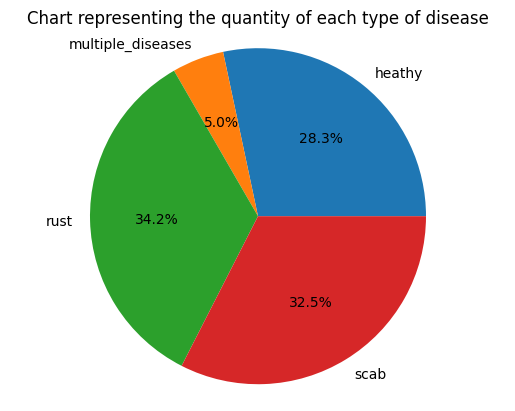

In [15]:
labels = ['heathy', 'multiple_diseases', 'rust', 'scab']
labels_count = [np.count_nonzero(train_labels==0),np.count_nonzero(train_labels==1),np.count_nonzero(train_labels==2),np.count_nonzero(train_labels==3)]

total_count = sum(labels_count)
percentages = [100.0 * count / total_count for count in labels_count]
# Draw pie chart
plt.pie(percentages, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Chart representing the quantity of each type of disease')
plt.show()
plt.show()


## II. Feature Extraction

In [14]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [15]:
# Extract feature from train images by using VGG model
feature_extractor=VGG_model.predict(train_img)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)


57/57 [==============================] - 1977s 35s/step


## III. Using SVM to train the classification model

In [16]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [17]:
# Based on the features of each image and the corresponding training label,
# we will construct the training and testing datasets.
# Split into the train/test with the radio 80/20
X_train, X_test, y_train, y_test = train_test_split(features, train_labels, test_size = 0.2, random_state= 42)

In [18]:
clf = SVC(probability = True, random_state= 42)
clf.fit(X_train, y_train)


SVC(probability=True, random_state=42)

In [19]:
y_pred = clf.predict_proba(X_test)
y_pred

array([[0.09538217, 0.09969668, 0.72258723, 0.08233392],
       [0.08250252, 0.05791983, 0.04252199, 0.81705566],
       [0.86770997, 0.01035237, 0.10422802, 0.01770964],
       ...,
       [0.02587405, 0.02424098, 0.9337806 , 0.01610438],
       [0.02012424, 0.15518513, 0.26224769, 0.56244293],
       [0.95111711, 0.00950794, 0.02509678, 0.01427817]])

In [24]:
y_pred_SVM = np.argmax(y_pred, axis=1)
acc = accuracy_score(y_test, y_pred_SVM)
print('Accuracy test:',acc)
print(classification_report(y_test, y_pred_SVM, zero_division=1.0))

Accuracy test: 0.7972602739726027
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       100
           1       1.00      0.00      0.00        18
           2       0.82      0.86      0.84       120
           3       0.80      0.83      0.81       127

    accuracy                           0.80       365
   macro avg       0.85      0.63      0.61       365
weighted avg       0.81      0.80      0.78       365



## IV. Using LDA to train the classification model

In [22]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA()
lda.fit(X_train,y_train)


LinearDiscriminantAnalysis()

In [23]:
y_pred_lda = lda.predict(X_test)
acc = accuracy_score(y_test, y_pred_lda)
print('Accuracy test:',acc)
print(classification_report(y_test, y_pred_lda))


Accuracy test: 0.5424657534246575
              precision    recall  f1-score   support

           0       0.39      0.55      0.46       100
           1       0.00      0.00      0.00        18
           2       0.55      0.70      0.61       120
           3       0.84      0.46      0.60       127

    accuracy                           0.54       365
   macro avg       0.45      0.43      0.42       365
weighted avg       0.58      0.54      0.54       365



# Write the SVM model's predictions for the test images to a submission.csv

In [ ]:
data_test = pd.read_csv(project_dir + '/test.csv')
test_img = []
test_img_name = data_test['image_id'] + '.jpg'
for name in test_img_name:
  img = cv2.imread(project_dir + "/images/" + name, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (SIZE, SIZE))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  test_img.append(img)

test_img = np.array(test_img)


In [25]:
test_feature_extractor = VGG_model.predict(train_img)
test_feature = test_feature_extractor.reshape(test_feature_extractor.shape[0],-1)

57/57 [==============================] - 2018s 35s/step


In [34]:
# Predict class for test image
test_pred = clf.predict_proba(test_feature)
test_pred

array([[0.00298979, 0.03663628, 0.00918611, 0.95118782],
       [0.00000012, 0.99953029, 0.00035688, 0.00011271],
       [0.70971002, 0.0163637 , 0.05940709, 0.2145192 ],
       ...,
       [0.79359668, 0.01412298, 0.18252385, 0.00975649],
       [0.01229873, 0.01364966, 0.96282464, 0.01122696],
       [0.00843426, 0.01066154, 0.00758608, 0.97331812]])

In [35]:
submission = pd.read_csv(project_dir + '/sample_submission.csv')
submission.loc[:,'healthy':] = test_pred
submission.to_csv(project_dir + '/submission.csv')
submission

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,2.989792e-03,0.036636,0.009186,0.951188
1,Test_1,1.241253e-07,0.999530,0.000357,0.000113
2,Test_2,7.097100e-01,0.016364,0.059407,0.214519
3,Test_3,4.951763e-03,0.005245,0.987742,0.002061
4,Test_4,9.643798e-01,0.002010,0.025408,0.008202
...,...,...,...,...,...
1816,Test_1816,6.048063e-02,0.078307,0.362882,0.498330
1817,Test_1817,9.754926e-01,0.009047,0.007356,0.008104
1818,Test_1818,7.935967e-01,0.014123,0.182524,0.009756
1819,Test_1819,1.229873e-02,0.013650,0.962825,0.011227
